# Quantum Approximate Optimization Algorithm 

We demonstrate how to implement QAOA using Pauli Propagation. Specifically, we solve the Max-Cut problem for two graphs, first a smaller graph and then for a large graph with IBM's heavy-hex lattice topology.

<div align="center">
    <img width=300 src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Max-cut.svg/1280px-Max-cut.svg.png alt='max cut exmaple'/>
</div>
Max cut example on 5 nodes. Image from Wikipedia

## Requirements

The notebooks uses the libraries which can be installed using:

* `Pkg.add("Graphs")` to create graphs.
* `Pkg.add("GraphRecipes")` and `Pkg.add("Plots")` for visualizng graphs and plots.
* `Pkg.add("JuMP")` and `Pkg.add("SCIP")` to solve problem classically.
* `Pkg.add("Optim")` for optimizing circuit.

## Background Max-Cut

Given a graph $G = (V,E)$, the goal of max-cut is partition the vertices into two disjoint sets such that the number of edges between them is maximzed i.e. the goal is to maximize the number of cut edges.

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

where $x_i$ and $x_j$ are binary variables for vertex $i$ and $j$. This represents a Quadratic Unconstrained Binary Optimization (QUBO) problem which, in matrix notation can be written as

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

where $Q$ is $n \times n$ matrix and $x$ is a bianry vector of size n.

## QAOA with small graph

We start with a small graph that is shown above.

In [1]:
using PauliPropagation
using Graphs
using GraphRecipes, Plots
using JuMP, SCIP
using Random
using Optim
using LinearAlgebra

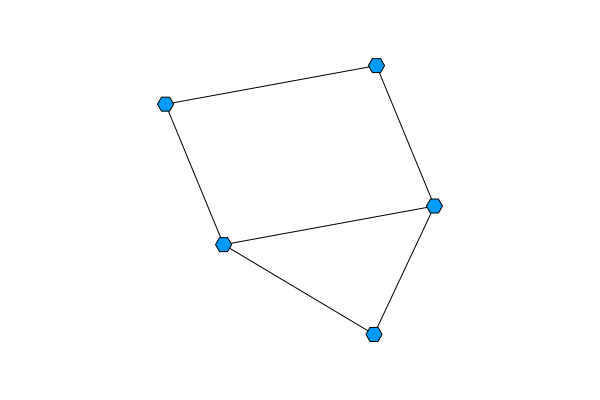

In [2]:
n = 5
edgelist = [(1, 2), (1, 3), (1, 5), (2, 3), (3, 4), (4, 5)]

graph = SimpleGraph(n)
for (u, v) in edgelist
    add_edge!(graph, u, v)
end

graphplot(graph, curves=false)

In [3]:
# solve classically
function classical_maxcut_solver(g)
    model = Model(SCIP.Optimizer)
    set_attribute(model, "display/verblevel", 0)
    @variable(model, x[1:nv(g)], Bin)
    
    # Objective function (Max-Cut formulation)
    cut_sum = 0 
    for edge in edges(g)
        i, j = (Graphs.src(edge), Graphs.dst(edge))
        cut_sum += (x[i] + x[j] - 2 * x[i] * x[j])
    end
    
    # Set the objective function (maximize cut weight)
    @objective(model, Max, cut_sum);

    optimize!(model)
    bitstring = value.(x)
    max_cut_value = objective_value(model)

    return bitstring, max_cut_value
    
end

classical_maxcut_solver (generic function with 1 method)

In [4]:
runtime = @elapsed bistring, max_cut_value = classical_maxcut_solver(graph)
println("Runtime: $runtime seconds")

Runtime: 6.476548786 seconds


In [5]:
max_cut_value

5.0

### Hamiltonian construction

We need to convert the objective function of the graph to Hamiltonian in order to use it with QAOA. To reformulate the QAOA problem to Hamiltonian, we can replace $x_i$ by and operator $X_i$ which is expressed in terms of Pauli-Z operator $Z_i$

$$
X_i = \frac{I-Z_i}{2}
$$

$X_i$ is diagonal with respect to computational basis and its eigenvalues are $0, 1$. Then the Hamiltonain can be written as

$$
\frac{1}{2} \sum_{(i,j)} \big(2 - Z_i - Z_j - (1 - Z_i)(I - Z_j)\big) = \frac{1}{2}|E| - \frac{1}{2} \sum_{(i, j)} Z_i Z_j.
$$

In the last equation, $|E|$ denotes the number of edges in the graph. Usually we minimize a function (eg. finding ground state of the Hamiltonian) so we flip the sign and write the cost Hamiltonian as 

$$
H_c = \frac{1}{2} \sum_{(i, j)} Z_i Z_j - \frac{1}{2}|E|
$$

In [6]:
# construct hamiltonian
function construct_cost_hamiltonian(g)
    n_edges = ne(g)
    n_nodes = nv(g)
    opsum = PauliSum(n_nodes)
    add!(opsum, repeat([:I], n_nodes), collect(1:n_nodes), -n_edges/2)
    for edge in edges(g)
        pair = (Graphs.src(edge), Graphs.dst(edge))
        add!(opsum, [:Z, :Z], collect(pair), 0.5)
    end
    return opsum
end

construct_cost_hamiltonian (generic function with 1 method)

In [7]:
opsum = construct_cost_hamiltonian(graph)
opsum

PauliSum(nqubits: 5, 7 Pauli terms:
 -3.0 * IIIII
 0.5 * ZIZII
 0.5 * ZZIII
 0.5 * IZZII
 0.5 * IIZZI
 0.5 * ZIIIZ
 0.5 * IIIZZ
)

### Circuit Construction

The idea of QAOA is to start from the ground state of a known Hamiltonian $H^{\otimes n}|0\rangle$ and then slowly evolve the system into the ground state of the cost hamiltonian. In practice, this is achieved by applying the operators $\exp(-i\gamma_k H_C)$ and $\exp(-i\beta_k) H_m$. The QAOA circuit will be parameterised by $\gamma_i$ and $\beta_i$, and the goal is to find optimum value of these parameters.

![QAOA circuit](qaoa_circuit.png)

In [8]:
# construct the circuit
function construct_qaoa_circuit(g, p = 2)
    circuit::Vector{Gate} = []
    edgelist = [(Graphs.src(edge), Graphs.dst(edge)) for edge in edges(g)]
    for i in 1:p
        rzzlayer!(circuit, edgelist)
        rxlayer!(circuit, n)
    end
    return circuit
end

construct_qaoa_circuit (generic function with 2 methods)

In [9]:
p = 2
circuit = construct_qaoa_circuit(graph, p)
countparameters(circuit)

22

The parameters in QAOA circuit with $p$ layers are $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. So with $p=$, we have $4$ parameters $\gamma_1,\gamma_2$ and $\beta_1, \beta_2~$. However, here we see $22$ parameters because `PauliPropagation` assigns each gate an independent parameters so it has $p(|E| + |V|)$ parameters i.e. $2(6 + 5) = 22$. We will see below a workaround for this.

### Circuit Optimization

We need to final the optmial parameters $\gamma_i$ and $\beta_i$ by iterative optimization loop. We first start with random initial values of the parameters and iteratively optimize them using a classical optimizer.

#### Initial Parameters

We randomly choose $2p$ initial parameters.

In [10]:
Random.seed!(42)
x0 = rand(-π:0.01:π, 2 * p)

4-element Vector{Float64}:
  0.8084073464102071
 -0.31159265358979304
 -0.14159265358979312
  1.2784073464102068

The below function handles assignment of parameters to quantum circuit. Given list of `params` which is of the following format

$$
$\gamma_1, \beta_1, \gamma_2, \beta_2...,\gamma_p, \beta_p$
$$

It expands the `params` array by repeating each $\gamma_i$ $|E|$ times and $\beta_i$ $|V|$ times which results into the following array.

$$
\underbrace{\gamma_1, ..., \gamma_1}_{\text{$|E|$ times}}, \underbrace{\beta_1,...,\beta_1}_{\text{$|V|$ times}}, ... , \underbrace{\gamma_p, ..., \gamma_p}_{\text{$|E|$ times}}, \underbrace{\beta_p,...,\beta_p}_{\text{$|V|$ times}}
$$

In [11]:
function expand_params(params, n_edges, n_qubits)
    # Extract gammas and betas
    gammas = params[1:2:end]  # Select every other column starting from the first column
    betas = params[2:2:end]   # Select every other column starting from the second column

    # Repeat gammas and betas
    gamma_expanded = repeat(gammas, 1, n_edges)  # Repeat along the third dimension (n_edges)
    beta_expanded = repeat(betas, 1, n_qubits)  # Repeat along the third dimension (n_qubits)

    # Concatenate gammas and betas along the third dimension
    expanded_layers = hcat(gamma_expanded, beta_expanded)
    expanded_params = reshape(expanded_layers', :)

    return expanded_params
end

expand_params (generic function with 1 method)

In [12]:
function execute(params, ansatz, hamiltonian, kwargs)
    psum = propagate(ansatz, hamiltonian, params; 
                     min_abs_coeff=get(kwargs, "min_abs_coeff", 1e-10),
                     max_weight=get(kwargs, "max_weight", Inf))
    return overlapwithplus(psum)  # Overlap with ground state of Mixer Hamiltonian
end

execute (generic function with 1 method)

In [13]:
function callback(obj)
    push!(objective_func_vals, obj.value)
    false
end

callback (generic function with 1 method)

In [14]:
function cost_func_estimator(params, ansatz, hamiltonian, g, kwargs)
    params = expand_params(params, ne(g), nv(g))
    result = execute(2 * params, ansatz, hamiltonian, kwargs)
    return result
end

cost_func_estimator (generic function with 1 method)

In [15]:
objective_func_vals = []  # Global variable
options = Optim.Options(callback=callback, iterations=100, show_trace=true)

kwargs_dict = Dict("min_abs_coeff" => 1e-8, "max_weight" => Inf)
objective = x -> cost_func_estimator(x, circuit, opsum, graph, kwargs_dict)

runtime = @elapsed res = optimize(objective, x0, LBFGS(), options)

Iter     Function value   Gradient norm 
     0    -2.977735e+00     6.933932e-01
 * time: 0.02473282814025879
     1    -3.339537e+00     2.661746e+00
 * time: 0.8954548835754395
     2    -3.360506e+00     2.304349e+00
 * time: 0.9314789772033691
     3    -3.969042e+00     1.695792e+00
 * time: 0.9361169338226318
     4    -4.030137e+00     8.716082e-01
 * time: 0.939140796661377
     5    -4.070917e+00     1.158656e+00
 * time: 0.9431829452514648
     6    -4.125532e+00     1.209583e+00
 * time: 0.9476640224456787
     7    -4.179554e+00     1.051272e+00
 * time: 0.9522178173065186
     8    -4.313921e+00     1.350346e+00
 * time: 0.9595479965209961
     9    -4.389591e+00     8.876652e-01
 * time: 0.9640698432922363
    10    -4.436150e+00     5.684738e-01
 * time: 0.96878981590271
    11    -4.489207e+00     4.256322e-01
 * time: 0.9717848300933838
    12    -4.494178e+00     1.679592e-01
 * time: 0.9747869968414307
    13    -4.495871e+00     8.184378e-02
 * time: 0.979277849197

3.471666996

In [16]:
res

 * Status: success

 * Candidate solution
    Final objective value:     -4.495975e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.23e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.03e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-16 ≰ 0.0e+00
    |g(x)|                 = 2.93e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    18
    f(x) calls:    52
    ∇f(x) calls:   52


In [17]:
opt_params = Optim.minimizer(res)
opt_value = Optim.minimum(res)

println("Final overlap: ", opt_value)
println("Best parameters: ", opt_params)
println("Final cost func evaluation:", objective(opt_params))
println("Runtime: $runtime seconds")

Final overlap: -4.495975211876401
Best parameters: [0.5135849485104381, 0.32466618762385063, -0.21326081916039402, 0.8869032936093207]
Final cost func evaluation:-4.495975211876401
Runtime: 3.471666996 seconds


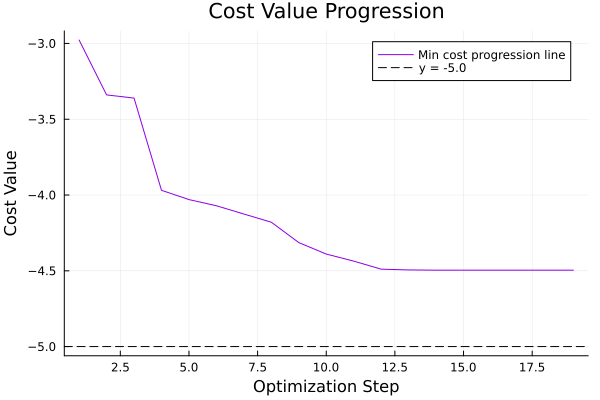

In [18]:
x_vals = 1:length(objective_func_vals)
p1 = plot(x_vals, objective_func_vals, label="Min cost progression line", linecolor="#8d00e7")
hline!(p1, [-max_cut_value], linestyle=:dash, color=:black, label="y = -$(max_cut_value)") # Add horizontal line
xlabel!(p1, "Optimization Step")
ylabel!(p1, "Cost Value")
title!(p1, "Cost Value Progression")
display(p1)

## QAOA on IBM's heavy-hex lattice

Let's scale the problem to a 127 qubits with topology of IBM's heavy-hex lattice. 

In [19]:
(@isdefined coord_map) || (const coord_map = [
    [0, 0],
    [0, 1],
    [0, 2],
    [0, 3],
    [0, 4],
    [0, 5],
    [0, 6],
    [0, 7],
    [0, 8],
    [0, 9],
    [0, 10],
    [0, 11],
    [0, 12],
    [0, 13],
    [1, 0],
    [1, 4],
    [1, 8],
    [1, 12],
    [2, 0],
    [2, 1],
    [2, 2],
    [2, 3],
    [2, 4],
    [2, 5],
    [2, 6],
    [2, 7],
    [2, 8],
    [2, 9],
    [2, 10],
    [2, 11],
    [2, 12],
    [2, 13],
    [2, 14],
    [3, 2],
    [3, 6],
    [3, 10],
    [3, 14],
    [4, 0],
    [4, 1],
    [4, 2],
    [4, 3],
    [4, 4],
    [4, 5],
    [4, 6],
    [4, 7],
    [4, 8],
    [4, 9],
    [4, 10],
    [4, 11],
    [4, 12],
    [4, 13],
    [4, 14],
    [5, 0],
    [5, 4],
    [5, 8],
    [5, 12],
    [6, 0],
    [6, 1],
    [6, 2],
    [6, 3],
    [6, 4],
    [6, 5],
    [6, 6],
    [6, 7],
    [6, 8],
    [6, 9],
    [6, 10],
    [6, 11],
    [6, 12],
    [6, 13],
    [6, 14],
    [7, 2],
    [7, 6],
    [7, 10],
    [7, 14],
    [8, 0],
    [8, 1],
    [8, 2],
    [8, 3],
    [8, 4],
    [8, 5],
    [8, 6],
    [8, 7],
    [8, 8],
    [8, 9],
    [8, 10],
    [8, 11],
    [8, 12],
    [8, 13],
    [8, 14],
    [9, 0],
    [9, 4],
    [9, 8],
    [9, 12],
    [10, 0],
    [10, 1],
    [10, 2],
    [10, 3],
    [10, 4],
    [10, 5],
    [10, 6],
    [10, 7],
    [10, 8],
    [10, 9],
    [10, 10],
    [10, 11],
    [10, 12],
    [10, 13],
    [10, 14],
    [11, 2],
    [11, 6],
    [11, 10],
    [11, 14],
    [12, 1],
    [12, 2],
    [12, 3],
    [12, 4],
    [12, 5],
    [12, 6],
    [12, 7],
    [12, 8],
    [12, 9],
    [12, 10],
    [12, 11],
    [12, 12],
    [12, 13],
    [12, 14],
]);


In [20]:
topology = Tuple{Int, Int}[]
for (ii, coord) in enumerate(coord_map)
    for (jj, coord2) in enumerate(coord_map[ii+1:end])
        if LinearAlgebra.norm(coord - coord2, 1) ≈ 1.0
            push!(topology, (ii, ii + jj))
        end
    end
end

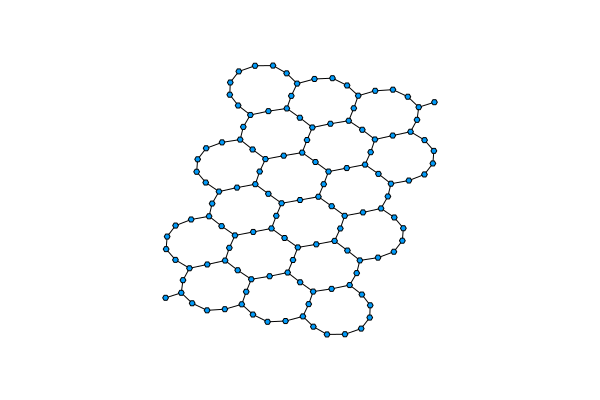

In [21]:
n = 127
graph_hex = SimpleGraph(n)
for (u, v) in topology
    add_edge!(graph_hex, u, v)
end

graphplot(graph_hex, curves=false)

### Solve classically

In [22]:
runtime = @elapsed bistring, max_cut_value = classical_maxcut_solver(graph_hex)
println("Runtime: $runtime seconds")
max_cut_value

Runtime: 0.017772 seconds


144.0

### Hamiltonian Construction

In [23]:
opsum_hex = construct_cost_hamiltonian(graph_hex)
opsum_hex

PauliSum(nqubits: 127, 145 Pauli terms:
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIZZIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIIZ...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIZZIIIIII...
 0.5 * IIIIIIIIIIIIZIIIIZII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIZZIIIIIIIIIII...
 0.5 * ZIIIIIIIIIIIIIZIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

### Circuit Construction

In [24]:
p = 2
circuit_hex = construct_qaoa_circuit(graph_hex, p)
countparameters(circuit_hex)

542

### Circuit Optimization

#### Initialize parameters

In [25]:
Random.seed!(42)
x0 = rand(-π:0.01:π, 2 * p)

4-element Vector{Float64}:
  0.8084073464102071
 -0.31159265358979304
 -0.14159265358979312
  1.2784073464102068

In [26]:
objective_func_vals = []  # Global variable
options = Optim.Options(callback=callback, iterations=100, show_trace=true)

kwargs_dict = Dict("min_abs_coeff" => 1e-6, "max_weight" => 8)
objective_hex = x -> cost_func_estimator(x, circuit_hex, opsum_hex, graph_hex, kwargs_dict)

runtime = @elapsed res = optimize(objective_hex, x0, LBFGS(), options)

Iter     Function value   Gradient norm 
     0    -7.513363e+01     6.682669e+01
 * time: 5.0067901611328125e-5
     1    -9.584759e+01     8.878054e+01
 * time: 6.801580190658569
     2    -1.007783e+02     5.532401e+01
 * time: 11.270841121673584
     3    -1.033613e+02     1.995748e+01
 * time: 15.404088020324707
     4    -1.037617e+02     8.983847e+00
 * time: 16.452917098999023
     5    -1.046874e+02     1.382487e+01
 * time: 17.663947105407715
     6    -1.054419e+02     1.014035e+01
 * time: 19.13800621032715
     7    -1.057006e+02     1.342288e+01
 * time: 20.374303102493286
     8    -1.060290e+02     1.717644e+01
 * time: 21.63166117668152
     9    -1.072683e+02     2.673663e+01
 * time: 23.515687227249146
    10    -1.083862e+02     3.145702e+01
 * time: 24.816203117370605
    11    -1.097294e+02     3.133622e+01
 * time: 26.76314902305603
    12    -1.111721e+02     2.992544e+01
 * time: 28.063356161117554
    13    -1.132659e+02     2.023996e+01
 * time: 29.3563032150

45.845636062

In [27]:
res

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     -1.148400e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.28e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.96e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.26e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.71e-16 ≰ 0.0e+00
    |g(x)|                 = 3.11e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    23
    f(x) calls:    79
    ∇f(x) calls:   79


In [28]:
opt_params = Optim.minimizer(res)
opt_value = Optim.minimum(res)

println("Final overlap: ", opt_value)
println("Best parameters: ", opt_params)
println("Final cost func evaluation:", objective(opt_params))
println("Runtime: $runtime seconds")

Final overlap: -114.84000077494375
Best parameters: [-12.848026758803123, 5.279665662458698, -6.80822457243345, 1.8698765804040371]
Final cost func evaluation:-4.594177435571282
Runtime: 45.845636062 seconds


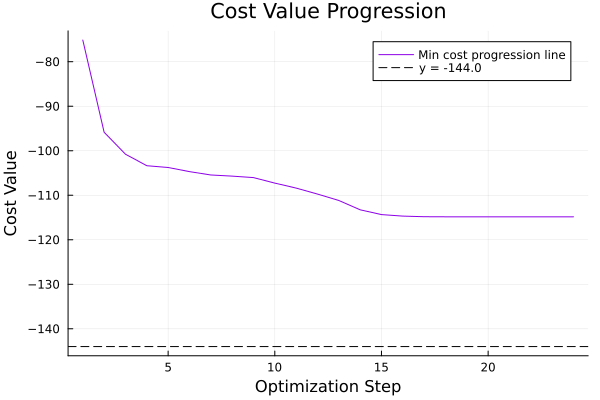

In [29]:
x_vals = 1:length(objective_func_vals)
p1 = plot(x_vals, objective_func_vals, label="Min cost progression line", linecolor="#8d00e7")
hline!(p1, [-max_cut_value], linestyle=:dash, color=:black, label="y = -$(max_cut_value)") # Add horizontal line
xlabel!(p1, "Optimization Step")
ylabel!(p1, "Cost Value")
title!(p1, "Cost Value Progression")
display(p1)

## Conclusion

We demonstrated how to use `PauliPropagation` to solve Max-cut problem using QAOA. We started with a toy example and scaled it to larger graph equal to number of qubits of IBM's current devices. By choosing appropriate values of `min_abs_coeff` and `max_weight`, we ensure feasibility of classical simulation of large quantum circuits.